# De novo design

### Developers: Mat Bieniek, Ben Cree, Rachael Pirie, Josh Horton

* Add R-groups in user-defined positions
* Output ADMET properties
* Perform constrained optimisation
* Score poses
* Send output to free energy calculations

Open source, customisable, fast/easy to use.

In [1]:
import copy
import glob
import prody
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
from rgroup import RMol, RList, build_molecules, fix_receptor, optimise_in_receptor, RGroups, sort_conformers, ic50

<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


In [2]:
%cd ~/rgroups/dat/thrombin/19jan
%pwd

/home/c0065492/rgroups/dat/thrombin/19jan


'/home/c0065492/rgroups/dat/thrombin/19jan'

In [3]:
prefix = 'lig_' #to extract experimental data from ligands.yml

In [4]:
!wget -nc https://files.rcsb.org/download/2ZFF.pdb
pdb = '2ZFF.pdb'

File ‘2ZFF.pdb’ already there; not retrieving.



In [5]:
RMol.set_gnina(loc='/home/c0065492/software/gnina')

In [6]:
# load the complex with the ligand
sys = prody.parsePDB(pdb)
#sys = prody.parsePDB('jnk1/2gmx.pdb')

rec = sys.select('not (nucleic or hetatm) and not water')
#mol = sys.select('resname 19H and chain A')
mol = sys.select('resname 0X5')

prody.writePDB('rec.pdb', rec)
#prody.writePDB('lig.pdb', mol)

@> 2527 atoms and 1 coordinate set(s) were parsed in 0.04s.


'rec.pdb'

In [7]:
#!wget 'https://models.rcsb.org/v1/5nev/ligand?auth_seq_id=301&label_asym_id=E&encoding=sdf&filename=5nev_E_72L.sdf' -O lig.sdf
#!obabel jnk1/core.sdf -O jnk1/coreh.sdf -p 7
!obabel -isdf core.sdf -osdf -O coreh.sdf -p 7
# ^manually modify the files if need be
%pwd

1 molecule converted


'/home/c0065492/rgroups/dat/thrombin/19jan'

In [8]:
# load the ligand
# rdkit doesn't do a good job with protonation, 
#init_mol = Chem.MolFromPDBFile('lig.pdb', removeHs=False)
#init_mol = Chem.AddHs(init_mol, addCoords=True)

init_mol = Chem.SDMolSupplier('coreh.sdf', removeHs=False)[0]

# get the R group representation of the rdkit Mol
rinit_mol = RMol(init_mol)

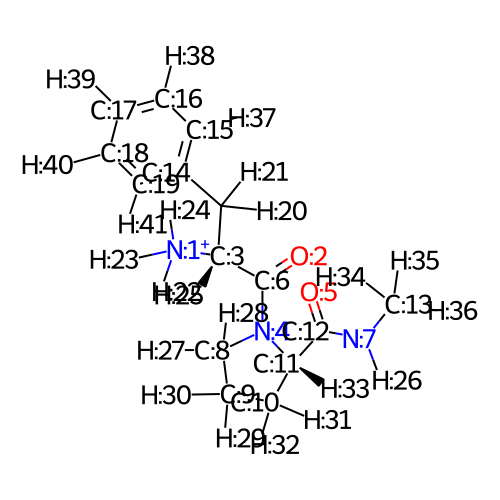

In [9]:
# select the atom to be replaced with the R group
rinit_mol.rep2D(idx=True, size=(500, 500))

In [10]:
#remove 44 since all conformers clash with protein
ligand_ids = ['1a','1b','1c','1d','3a','3b','5', '6a', '6b', '6e', '7a']
#ligand_ids = ['13c', '13d', '13h', '17c', '17h']
# read the rgroups 1 by 1 in a loop
# assumes that there is only one -r.mol in each dir
rgroups = [Chem.MolFromMolFile(glob.glob(f'{ligand_id}/*.mol')[0], removeHs=False) for ligand_id in ligand_ids]
rgroups

In [11]:
ligand_ids[0] #to check what rgroup is failing optimisation or clash with protein

'1a'

In [12]:
# build a list of molecules
attachment_index = [36]
rmols = build_molecules(rinit_mol, attachment_index, rgroups)

Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7ff5743f8040> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7ff5743f80a0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7ff5743f8460> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7ff5743f83a0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7ff5743f8040> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7ff5743f80a0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7ff5743f8460> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7ff5743f83a0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7ff5743f8040> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7ff5743f80a0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7ff5743f8460> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7ff5743f83a0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7ff5743f8040> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7ff5743f80a0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom o

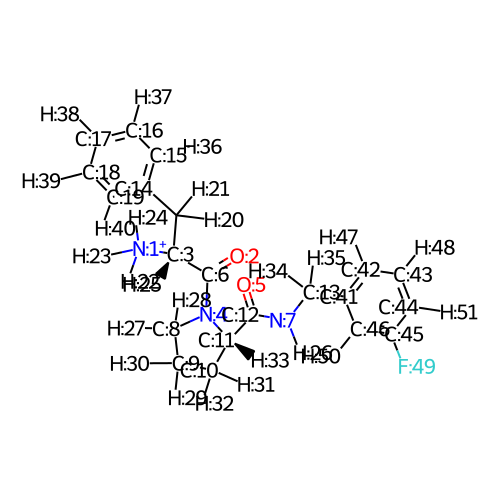

In [13]:
rmols[0].rep2D(idx=True, size=(500, 500))

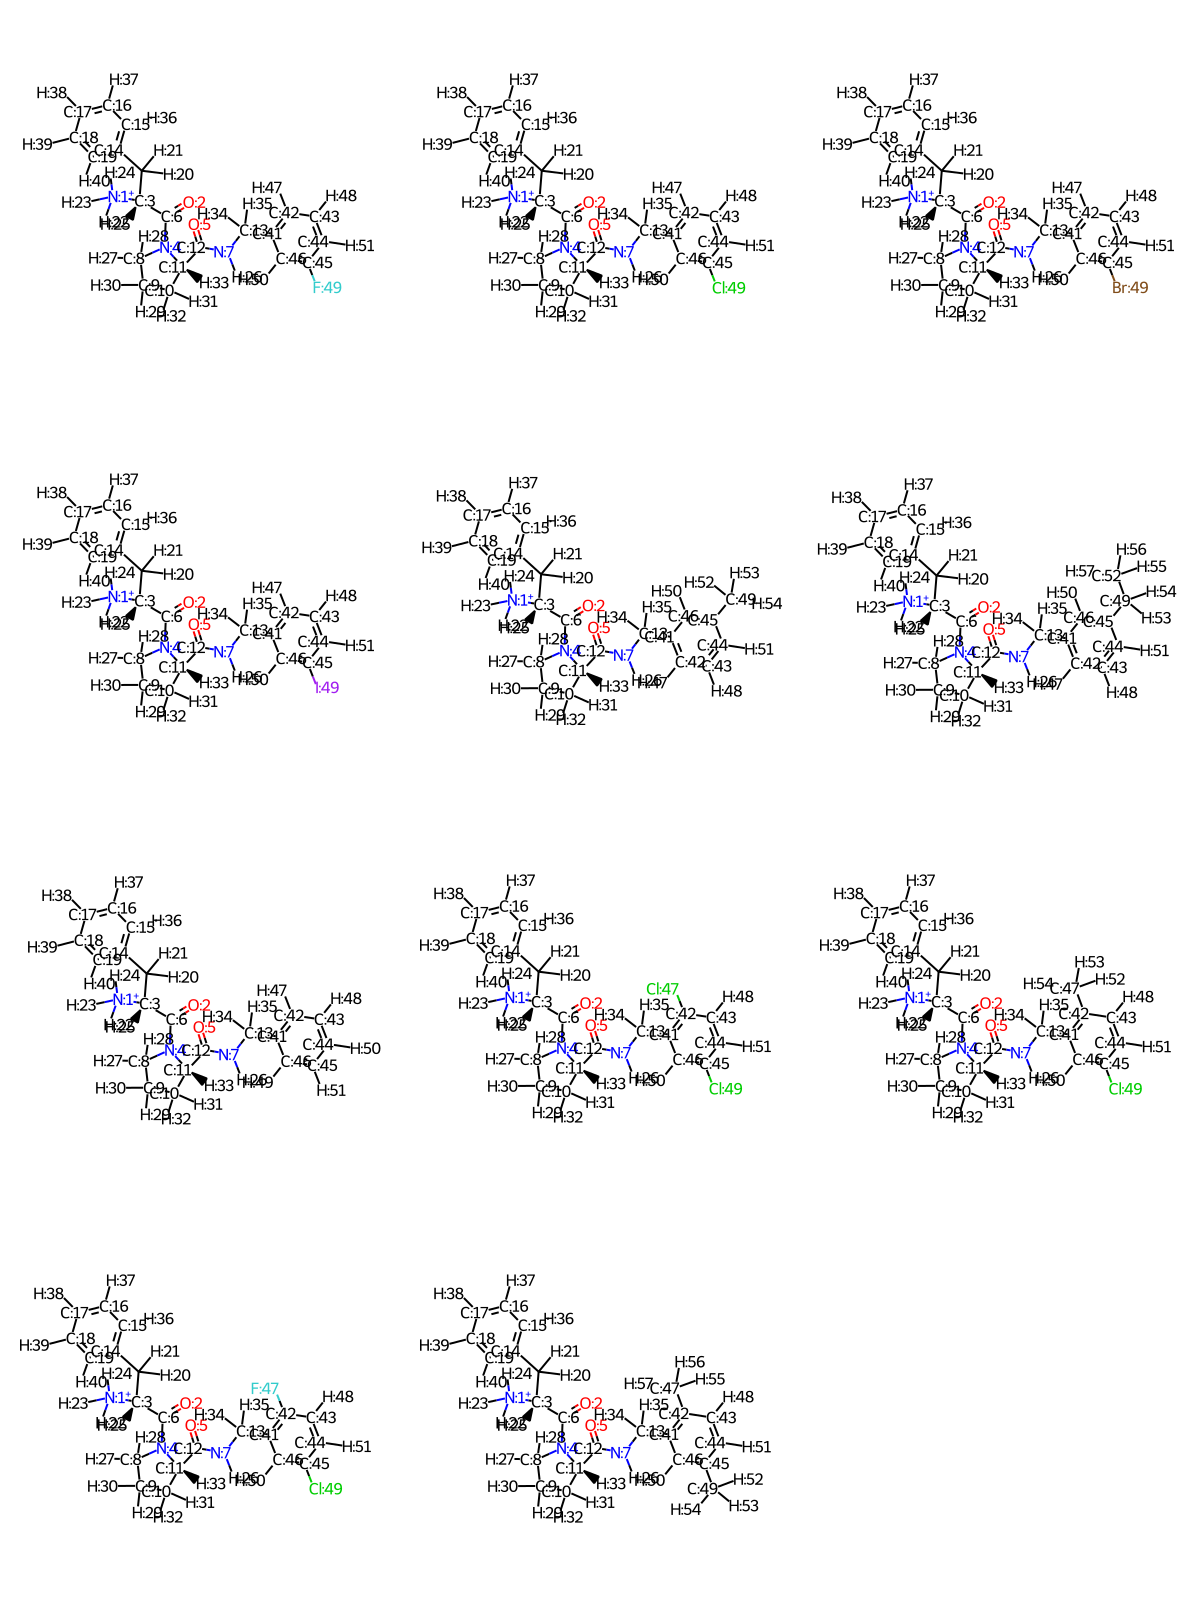

In [14]:
rmols.rep2D()

In [15]:
rmols[3].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [16]:
rmols.toxicity()

,MW,HBA,HBD,LogP,Pass_Ro5,has_pains,has_unwanted_subs,has_prob_fgs,synthetic_accessibility
0,370.192532,2,2,1.28610,True,False,False,False,8.117124
0,386.162981,2,2,1.80040,True,False,False,False,8.115170
0,430.112466,2,2,1.90950,True,False,False,False,8.128635
0,478.098601,2,2,1.75160,True,False,True,False,8.150942
0,366.217604,2,2,1.45542,True,False,False,False,8.293222
0,380.233254,2,2,1.70940,True,False,False,False,8.372898
0,352.201953,2,2,1.14700,True,False,False,False,8.189148
0,420.124009,2,2,2.45380,True,False,False,False,7.960341
0,400.178631,2,2,2.10882,True,False,False,False,8.218124
0,404.153559,2,2,1.93950,True,False,False,False,7.976481


In [17]:
rmols.generate_conformers(num_conf=200,
                         minimum_conf_rms=0.5,
                         flexible = [13, 34, 35]
                         )

RMol index 0
removed 191 duplicated conformations
RMol index 1
removed 191 duplicated conformations
RMol index 2
removed 192 duplicated conformations
RMol index 3
removed 192 duplicated conformations
RMol index 4
removed 183 duplicated conformations
RMol index 5
removed 168 duplicated conformations
RMol index 6
removed 191 duplicated conformations
RMol index 7
removed 188 duplicated conformations
RMol index 8
removed 181 duplicated conformations
RMol index 9
removed 191 duplicated conformations
RMol index 10
removed 160 duplicated conformations


In [18]:
#rmol.rep3D(template=True)

In [19]:
rmols.GetNumConformers()

[10, 10, 9, 9, 18, 33, 10, 13, 20, 10, 41]

### Optimise conformers in context of protein

In [20]:
# fix the receptor file 
fix_receptor("rec.pdb", "rec_h.pdb")
# load back into prody
rec_fix = prody.parsePDB("rec_h.pdb")

@> 4636 atoms and 1 coordinate set(s) were parsed in 0.03s.


In [21]:
# filter by the protein clashes
rmols[2].rep3D(prody=rec_fix)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [22]:
rmols.removeConfsClashingWithProdyProt(rec_fix)

RMol index 0
Clash with the protein. Removing conformer id: 9
Clash with the protein. Removing conformer id: 7
Clash with the protein. Removing conformer id: 5
Clash with the protein. Removing conformer id: 4
Clash with the protein. Removing conformer id: 3
Clash with the protein. Removing conformer id: 2
RMol index 1
Clash with the protein. Removing conformer id: 9
Clash with the protein. Removing conformer id: 8
Clash with the protein. Removing conformer id: 7
Clash with the protein. Removing conformer id: 6
Clash with the protein. Removing conformer id: 5
Clash with the protein. Removing conformer id: 4
Clash with the protein. Removing conformer id: 3
Clash with the protein. Removing conformer id: 2
Clash with the protein. Removing conformer id: 1
RMol index 2
Clash with the protein. Removing conformer id: 7
Clash with the protein. Removing conformer id: 6
Clash with the protein. Removing conformer id: 5
Clash with the protein. Removing conformer id: 4
Clash with the protein. Removi

In [23]:
rmols.GetNumConformers()

[4, 1, 2, 1, 3, 3, 4, 3, 4, 3, 2]

In [24]:
rmols[2].rep3D(prody=rec_fix)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [25]:
# opt_mol, energies
energies = rmols.optimise_in_receptor(
    receptor_file="rec_h.pdb", 
    ligand_force_field="openff", 
    use_ani=True,
    sigma_scale_factor=0.8,
    relative_permittivity=4
)

RMol index 0


Optimising conformer: 100%|███████████████████████| 4/4 [00:12<00:00,  3.18s/it]


RMol index 1


Optimising conformer: 100%|███████████████████████| 1/1 [00:02<00:00,  2.71s/it]


RMol index 2


Optimising conformer: 100%|███████████████████████| 2/2 [00:05<00:00,  2.54s/it]


RMol index 3


Optimising conformer: 100%|███████████████████████| 1/1 [00:04<00:00,  4.01s/it]


RMol index 4


Optimising conformer: 100%|███████████████████████| 3/3 [00:07<00:00,  2.41s/it]


RMol index 5


Optimising conformer: 100%|███████████████████████| 3/3 [00:06<00:00,  2.12s/it]


RMol index 6


Optimising conformer: 100%|███████████████████████| 4/4 [00:08<00:00,  2.05s/it]


RMol index 7


Optimising conformer: 100%|███████████████████████| 3/3 [00:07<00:00,  2.64s/it]


RMol index 8


Optimising conformer: 100%|███████████████████████| 4/4 [00:07<00:00,  1.79s/it]


RMol index 9


Optimising conformer: 100%|███████████████████████| 3/3 [00:08<00:00,  2.74s/it]


RMol index 10


Optimising conformer: 100%|███████████████████████| 2/2 [00:05<00:00,  2.62s/it]


In [26]:
rmols[0].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [27]:
for i in range(len(ligand_ids)):
    rmols[i].to_file("optimised_coords_" + str(ligand_ids[i]) + ".pdb")

In [28]:
final_energies = rmols.sort_conformers(energy_range=5)

RMol index 0
RMol index 1
RMol index 2
RMol index 3
RMol index 4
RMol index 5
RMol index 6
RMol index 7
RMol index 8
RMol index 9
RMol index 10


In [29]:
len(ligand_ids) == len(rmols) #check theyre equal or very bad and silent things happen

True

In [30]:
for i in range(len(ligand_ids)):
    rmols[i].to_file("best_conformers_" + str(ligand_ids[i]) + ".pdb")

In [31]:
#RMol.set_gnina(loc='gnina')

In [32]:
CNNscores = rmols.gnina(receptor_file="rec_h.pdb") 

RMol index 0
RMol index 1
RMol index 2
RMol index 3
RMol index 4
RMol index 5
RMol index 6
RMol index 7
RMol index 8
RMol index 9
RMol index 10


In [33]:
ic50_scores = []
for i in range(len(CNNscores)):
    ic50_scores.append([ic50(x) for x in CNNscores[i]])

In [34]:
for i in range(len(ic50_scores)):
    with open('scores_' + str(ligand_ids[i]) + '.dat', 'w') as f:
        for x in range(len(ic50_scores[i])):
            f.write(str(ic50_scores[i][x])+'\n')

In [35]:
lowest = []
for i in range(len(ic50_scores)):
    lowest.append(ic50_scores[i][0])

In [36]:
import yaml
with open("ligands.yml", "r") as stream:
    try:
        data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

experimental = []
for i in range(len(ligand_ids)):
    experimental.append(data[prefix+ ligand_ids[i]]['measurement']['value'])
experimental = [i*0.2390057361 for i in experimental] #for some reason no ic50 values only kJ/mol

In [37]:
import pandas as pd

name = [ligand_ids[i:i+1] for i in range(0, len(ligand_ids), 1)]
energies = [i[0] for i in final_energies]
cnn = [i[0] for i in CNNscores]
ic50 = [i[0] for i in ic50_scores]
expt = [i for i in experimental]
output = pd.DataFrame({'ID' : name, 'Final energies' : energies, 'Gnina score' : cnn, 'Gnina IC50 / nM' : ic50, 'Experimental IC50 / nM' : expt})
output

,ID,Final energies,Gnina score,Gnina IC50 / nM,Experimental IC50 / nM
0,[1a],0.0,6.45266,352.646843,-7.480880
1,[1b],0.0,6.76804,170.592526,-8.460803
2,[1c],0.0,6.77565,167.629326,-8.556405
3,[1d],0.0,6.83076,147.652226,-8.245698
4,[3a],0.0,6.50861,310.020206,-8.317400
5,[3b],0.0,6.66923,214.175604,-7.863289
6,[5],0.0,6.43969,363.337313,-7.576482
7,[6a],0.0,6.94101,114.548657,-9.177820
8,[6b],0.0,7.14331,71.893562,-8.891013
9,[6e],0.0,6.83830,145.110888,-8.914914


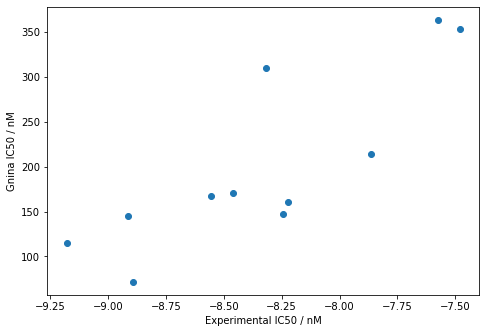

In [38]:
import matplotlib.pyplot as plt
import numpy as np

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(expt, lowest) #, color='black', marker='x')
ax.set_xlabel('Experimental IC50 / nM')
ax.set_ylabel('Gnina IC50 / nM')

x = np.linspace(50,200,25)
y = np.linspace(300,350,25)

plt.savefig('out.png', bbox_inches='tight')
plt.show()

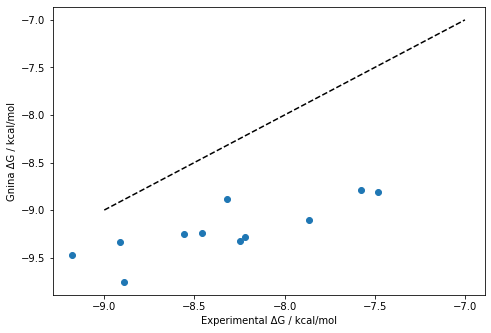

In [39]:
# convert nM to M
lowestinM = [ i * 1e-9 for i in lowest]


RT = 0.593 # kcal/mol

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

# DG = RTln(K)
ax.scatter(experimental, RT*np.log(lowestinM)) #, color='black', marker='x') #convert kJ to kcal
ax.set_xlabel('Experimental \u0394G / kcal/mol')
ax.set_ylabel('Gnina \u0394G / kcal/mol')

x = np.linspace(-9,-7.,10)
ax.plot(x, x, color='black', linestyle='--')
A = np.vstack([experimental, np.ones(len(experimental))]).T 
m, c = np.linalg.lstsq(A, lowest, rcond=None)[0]

m = "{:.2f}".format(m)
r = "r^2 =" + str(m)
plt.annotate(r, (-10,-6))
plt.savefig('deltaG2.png', bbox_inches='tight')
plt.show()

In [40]:
experimental

[-7.48087953993,
 -8.46080305794,
 -8.556405352379999,
 -8.24569789545,
 -8.31739961628,
 -7.86328871769,
 -7.57648183437,
 -9.17782026624,
 -8.89101338292,
 -8.914913956529999,
 -8.22179732184]

In [41]:
#filtered_ids = copy.copy(ligand_ids)
#for i in range(len(ligand_id_idx)):
#    filtered_ids.remove(ligand_ids[ligand_id_idx[i]])
#filtered_ids

In [42]:
filtered_ids = ligand_ids

In [43]:
import yaml
with open("ligands.yml", "r") as stream:
    try:
        data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
suffix = ''
experimental_filtered = []
for i in range(len(filtered_ids)):
    if data[prefix + str(filtered_ids[i])+suffix]['measurement']['unit'] == 'nM':
        print('found nM')
        experimental_filtered.append(data[prefix+ str(lfiltered_ids[i])+suffix]['measurement']['value'])
    elif data[prefix + str(filtered_ids[i])+suffix]['measurement']['unit'] == 'uM':
        print('found uM')
        experimental_filtered.append(1000*data[prefix+ str(filtered_ids[i])+suffix]['measurement']['value'])
    else:
        print('UNKNOWN UNIT - SKIPPING')
experimental_filtered

UNKNOWN UNIT - SKIPPING
UNKNOWN UNIT - SKIPPING
UNKNOWN UNIT - SKIPPING
UNKNOWN UNIT - SKIPPING
UNKNOWN UNIT - SKIPPING
UNKNOWN UNIT - SKIPPING
UNKNOWN UNIT - SKIPPING
UNKNOWN UNIT - SKIPPING
UNKNOWN UNIT - SKIPPING
UNKNOWN UNIT - SKIPPING
UNKNOWN UNIT - SKIPPING


[]

In [44]:
import re
smina_affinities = []
with open('smina_scores.dat', 'r') as f:
    for line in f:
        affinity = re.findall(r'Affinity: (-?\d+.\d+)', str(line))
        try:
            smina_affinities.append(float(affinity[0]))
        except:
            pass

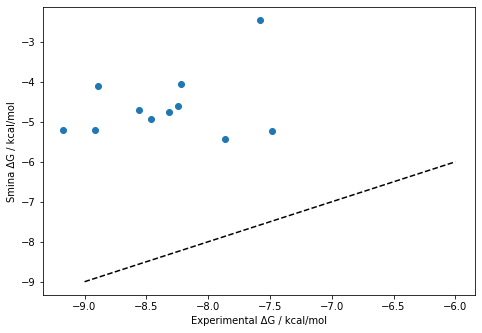

In [45]:


RT = 0.593 # kcal/mol

# convert nM to M

exptinM = [ i * 1e-9 for i in experimental]

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

# DG = RTln(K)
ax.scatter(experimental, smina_affinities) #, color='black', marker='x')
ax.set_xlabel('Experimental \u0394G / kcal/mol')
ax.set_ylabel('Smina \u0394G / kcal/mol')

x = np.linspace(-9.0,-6,10)
ax.plot(x, x, color='black', linestyle='--')
A = np.vstack([experimental, np.ones(len(experimental))]).T
#m, c = np.linalg.lstsq(A, lowest, rcond=None)[0]

#m = "{:.2f}".format(m)
#r = "r^2 =" + str(m)
#plt.annotate(r, (-10,-6))
plt.savefig('deltaG2_smina.png', bbox_inches='tight')
plt.show()

In [46]:
experimental

[-7.48087953993,
 -8.46080305794,
 -8.556405352379999,
 -8.24569789545,
 -8.31739961628,
 -7.86328871769,
 -7.57648183437,
 -9.17782026624,
 -8.89101338292,
 -8.914913956529999,
 -8.22179732184]

In [47]:
import dill
dill.dump_session('notebook_thrombin_19jan.db')